In [2]:
from model_explorer.result_handling.collect_results import collect_results

/home/itiv/oq4116/venvs/torch_exploration/lib64/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
results8x8 = collect_results('../results/different_ga_settings')
results8x8alt = collect_results('../results/expl_sparsity_problem_resnet50_imagenet_2023-02-02_15-17_slurmid_0.pkl')
results16x16 = collect_results('../results/expl_sparsity_problem_resnet50_imagenet_2023-02-02_15-13_slurmid_1.pkl')
results1x16 = collect_results('../results/expl_sparsity_problem_resnet50_imagenet_2023-02-02_15-23_slurmid_2.pkl')
results/reeval_sparsity_problem_resnet50_imagenet_2023-02-02_23-41-29_slurmid_0.csv
results/reeval_sparsity_problem_resnet50_imagenet_2023-02-02_23-49-22_slurmid_1.csv
results/reeval_sparsity_problem_resnet50_imagenet_2023-02-02_23-57-39_slurmid_2.csv

df8x8 = results8x8.to_dataframe()
df8x8alt = results8x8alt.to_dataframe()
df16x16 = results16x16.to_dataframe()
df1x16 = results1x16.to_dataframe()

# df8x8 = df8x8[df8x8['accuracy'] > 0.7]
# df8x8['F_0'] = -df8x8['F_0'] * 1_000_000
# df8x8 = df8x8[df8x8['accuracy'] > 0.7]
# df8x8['F_0'] = -df8x8['F_0'] * 1_000_000

In [18]:
def prepare(df):
    df = df[df['accuracy'] > 0.7]
    df['F_0'] = -df['F_0'] * 1_000_000
    return df

df8x8 = prepare(df8x8)
df1x16 = prepare(df1x16)
df16x16 = prepare(df16x16)
df8x8alt = prepare(df8x8alt)

/scratch/ipykernel_2342175/2659196221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['F_0'] = -df['F_0'] * 1_000_000


8x8 max: 62042.209716796875
16x16 max: 11137.314697265625
1x16 max: 231804.18041992188


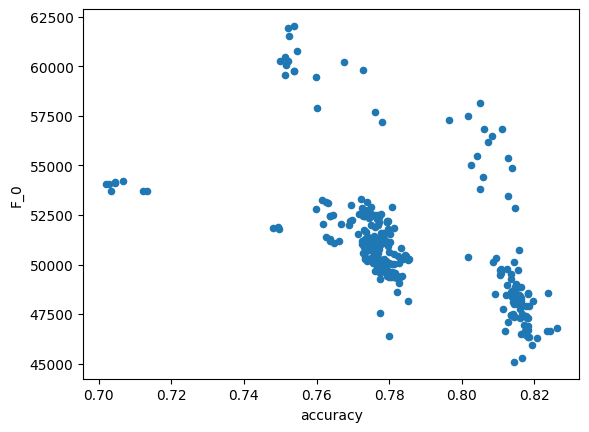

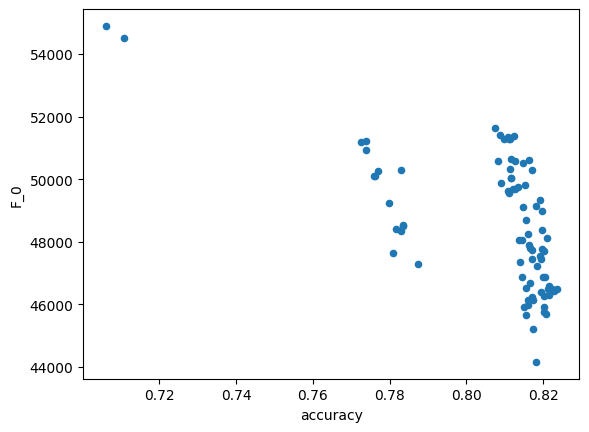

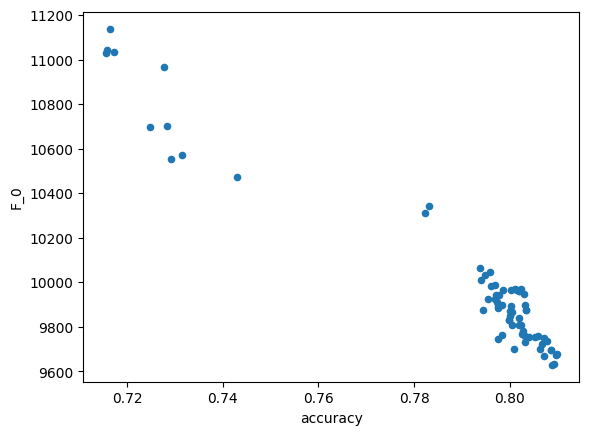

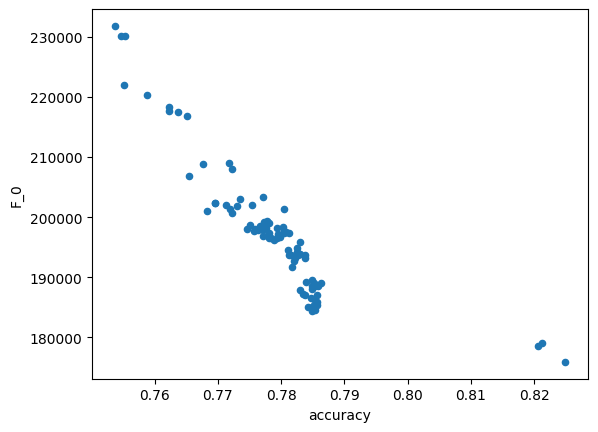

In [23]:

df8x8.plot(kind='scatter', x='accuracy', y='F_0')
df8x8alt.plot(kind='scatter', x='accuracy', y='F_0')
df16x16.plot(kind='scatter', x='accuracy', y='F_0')
df1x16.plot(kind='scatter', x='accuracy', y='F_0')

print(f"8x8 max: {df8x8['F_0'].max()}")
print(f"16x16 max: {df16x16['F_0'].max()}")
print(f"1x16 max: {df1x16['F_0'].max()}")